# Nanopore S3 Directory

In [ ]:
s3cmd get --recursive s3://aretian-genomics/nanopore/

# Reference Genome

Info: https://lh3.github.io/2017/11/13/which-human-reference-genome-to-use

In [ ]:
# Pull reference genome from S3
!s3cmd get s3://aretian-genomics/nanopore/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz

In [ ]:
!gunzip GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz

In [ ]:
# Index reference genome
!samtools faidx GCA_000001405.15_GRCh38_no_alt_analysis_set.fna

In [ ]:
# Select chromosomes or regions
!samtools faidx GCA_000001405.15_GRCh38_no_alt_analysis_set.fna chr17 > chr17_selected.fa

Import Chromosome 

In [498]:
# Read in fasta files
def read_fasta_genome(fasta_file,chromosome_header):
    clean_data = fasta_file.read().replace("\n", "")
    clean_data = clean_data.replace(chromosome_header,"") # get rid of header

    return clean_data

In [499]:
with open('../reference-genome/chr17_selected.fa') as f: # update path if needed
    ref_genome = read_fasta_genome(f,'>chr17')

See https://www.bioinformatics.org/sms/iupac.html for IUPAC nucleotide codes

In [500]:
print(f"Unique characters: {list(set(ref_genome))}") 

Unique characters: ['K', 'T', 'C', 'Y', 'W', 'N', 'S', 'R', 'G', 'A']


In [501]:
print(f"Selected chromosome from reference genome is {len(ref_genome)} BP long")

Selected chromosome from reference genome is 83257441 BP long


# Chromosome Selection (Nanopore)

In [2]:
!ls

0_basecalling.ipynb  2_quality_control.ipynb  basecaller.sh  README.md
1_alignment.ipynb    3_assembly.ipynb	      bioaretian.sh  read_overlap.ipynb


In [9]:
!cd ..

In [ ]:
#!view -c bioliquid_chr17_pompe.bam
#!samtools view bioliquid_chr17_pompe.bam | head -n 500 > bioliquid_chr17_pompe_500reads.txt

Samtools view --> format of output: http://samtools.github.io/hts-specs/SAMv1.pdf

In [502]:
import pandas as pd
nanopore_reads = pd.read_csv('../nanopore-data/bioliquid_chr17_pompe_reads.csv')
nanopore_reads['ID'] = nanopore_reads.index

In [503]:
nanopore_reads = nanopore_reads[['ID', 'QNAME', 'FLAG', 'RNAME', 'POS', 'MAPQ', 'CIGAR', 'RNEXT', 'PNEXT','TLEN', 'SEQ', 'QUAL']]
nanopore_reads = nanopore_reads.loc[nanopore_reads['SEQ'] != '*'] # drop any rows without a proper nucleotide sequence

View Read Overlap

In [504]:
import numpy as np
import matplotlib.pyplot as plt

In [505]:
nanopore_reads = nanopore_reads.sort_values(by='POS',ascending=True) # sort based on starting index of reads
nanopore_reads.head()

,ID,QNAME,FLAG,RNAME,POS,MAPQ,CIGAR,RNEXT,PNEXT,TLEN,SEQ,QUAL
296,296,6d90ffed-f2ed-4bf5-8fbe-d3bba26235d1,0,chr17,22936972,11,29S94M1I243M2D34M4D49M3I2M2D78M1D98M1D75M2D49M...,*,0,0,TGCTAGTGTTCTCAACAGTCAGTATTGCTATAGTTCAGCTTTGAAA...,NaN
63,63,7989fa5c-d565-486b-87bb-452f61888d68,16,chr17,22975697,2,21598S15M1I10M1D28M4D10M1D5M2D3M2D5M2D16M2D16M...,*,0,0,TTGACTCGTATTTATCACAAACAAGTTTTGTATGCCTCTCTCGGTT...,NaN
1022,1022,ebdd1129-003a-4f8d-acb4-72f40f4bbec8,16,chr17,22978432,1,6925S15M1D2M1D9M1D52M2I4M1D10M5D76M1I4M2I70M1D...,*,0,0,AATGTATTGCTGAAACTCTCTCGTGATGATTGCATTCAACTCACAG...,NaN
238,238,ec3a5d57-1638-4b83-8e4c-b87a980df149,0,chr17,22983246,1,30S19M2I26M1I49M3D3M1I24M1D9M1I94M1D51M1D3M1I3...,*,0,0,TGTCGTCTATTCGTTCGTTCGCTGCTGTACAGCGGATACTTGGGCC...,"%$##$'&'#*2,+3.()&)&&'/.)*'+)#%*06873++53.2736..."
341,341,20934f8a-dc46-46c6-bd80-b03dc048d8ee,0,chr17,22984020,1,61S16M2I11M1D2M1D5M1D9M4I4M1I4M1D87M1D12M1I3M2...,*,0,0,TCTGTGTGTGTCTTCGTTTCAGTTGCATCTGCTCAGAAACTTTCCT...,"##'*$'&'&&'#).#*$,.('1*,&'&&&*($)%+/0+-+$.%&%+..."


In [506]:
for ID in nanopore_reads.index:
    print(f"Leftmost index --> {nanopore_reads.loc[ID,'POS']}, Read length --> {len(nanopore_reads.loc[ID,'SEQ'])}")

Leftmost index --> 22936972, Read length --> 32759
Leftmost index --> 22975697, Read length --> 32759
Leftmost index --> 22978432, Read length --> 32759
Leftmost index --> 22983246, Read length --> 19609
Leftmost index --> 22984020, Read length --> 22347
Leftmost index --> 22990548, Read length --> 32759
Leftmost index --> 22990923, Read length --> 32759
Leftmost index --> 22997071, Read length --> 13985
Leftmost index --> 22999284, Read length --> 32759
Leftmost index --> 23004186, Read length --> 2416
Leftmost index --> 23006151, Read length --> 26632
Leftmost index --> 23006672, Read length --> 2883
Leftmost index --> 23006975, Read length --> 11655
Leftmost index --> 23007938, Read length --> 9218
Leftmost index --> 23008122, Read length --> 1896
Leftmost index --> 23008839, Read length --> 6011
Leftmost index --> 23009095, Read length --> 18853
Leftmost index --> 23010195, Read length --> 14205
Leftmost index --> 23010327, Read length --> 29026
Leftmost index --> 23011058, Read le

In [507]:
end_index = max(nanopore_reads['POS']) + len(nanopore_reads.loc[nanopore_reads['POS'].idxmax(),'SEQ'])
start_index = min(nanopore_reads['POS'])
index_range = end_index-start_index

In [508]:
read_overlap = np.zeros((len(nanopore_reads),index_range)) # empty matrix for reads

MemoryError: Unable to allocate 32.7 GiB for an array with shape (1080, 4062729) and data type float64

In [ ]:
for ID in nanopore_reads.index:
    print(f"Adding raad cover for read {ID+1}: Index-->{nanopore_reads.loc[ID,'POS']}, length-->{len(nanopore_reads.loc[ID,'SEQ'])}")
    start = test.loc[ID,'POS']-start_index
    #print(start)
    end = start+len(nanopore_reads.loc[ID,'SEQ'])
    #print(end)
    read_overlap[ID,start:end] = 1
    
summary = read_overlap.sum(axis=0)

In [ ]:
overlap_df = pd.DataFrame(data=summary,index=range(start_index,end_index), columns=['overlap_count'])
overlap_df['position'] = overlap_df.index

In [ ]:
fig, ax = plt.subplots(dpi=150)
plt.plot(df['position'],df['overlap_count'])
plt.xlabel('Nucleotide Position')
plt.ylabel('# Reads Overlapping')

Read statistics

In [509]:
# Check read length statistics
nanopore_reads['SEQ_LEN'] = nanopore_reads['SEQ'].apply(lambda x: len(x))
nanopore_reads['END_POS'] = nanopore_reads['POS']+nanopore_reads['SEQ_LEN']
print(f"Read length statistics:")
nanopore_reads['SEQ_LEN'].describe()

Read length statistics:


count     1080.000000
mean     11367.615741
std      10815.201656
min        100.000000
25%       2307.250000
50%       6254.000000
75%      18966.750000
max      32759.000000
Name: SEQ_LEN, dtype: float64

In [510]:
# Check read pos statistics
print(f"Read position statistics:")
nanopore_reads['POS'].describe()

Read position statistics:


count    1.080000e+03
mean     2.550694e+07
std      1.445399e+06
min      2.293697e+07
25%      2.419741e+07
50%      2.647332e+07
75%      2.661930e+07
max      2.699905e+07
Name: POS, dtype: float64

Trim reference genome chromosome to locus of interest 

In [511]:
ref_genome = ref_genome[min(nanopore_reads['POS']):max(nanopore_reads['END_POS'])]
print(f"Selected focus are for chromosome from reference genome is {len(ref_genome)} BP long")

Selected focus are for chromosome from reference genome is 4085413 BP long


# Sliding Window Assembly Algorithm (V1)

In [512]:
# Define hyper-parameters
window_width = 5000 # 5k BP
jump_width = 1000 # 1k BP sliding window (ideally jump_width=1)

Packages and libraries

In [513]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

In [514]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

Helper functions

In [515]:
# check if the start of a sequence is in range
def check_sliding_window(read):
    read_filter = False
    window = set(list(range(left_bound,right_bound)))
    read = set(list(range(read['POS'],read['END_POS'])))
    if len(window & read)>0:
        read_filter = True
    return read_filter

In [516]:
def left_pad_read(read):
    nucleotide_sequence = list(read['SEQ']) # turn sequence string into a list
    genome_sequence = list(window_ref_genome)
    
    start = read['POS']-left_bound

    if start == 0:
        return read['SEQ'] # read starts on the start of the window
    
    elif start > 0: # sequence starts to the right of the bound
        genome_fill = window_ref_genome[:start] # select portion of reference genome to pad the left with
        nucleotide_sequence = genome_fill+nucleotide_sequence
        nucleotide_sequence_trimmed = ''.join(nucleotide_sequence) # keep entire sequence
    
    elif start < 0: # sequence starts to the left of the bound
        nucleotide_sequence_trimmed = ''.join(nucleotide_sequence[np.abs(start):])
        return nucleotide_sequence_trimmed

In [517]:
def right_pad_read(read):
    nucleotide_sequence = list(read['left_padded']) # turn sequence string into a list
    genome_sequence = list(window_ref_genome)

    end = right_bound-read['END_POS']

    if end == 0:
        return read['left_padded'] # read end on the end of the window
    
    elif end > 0: # sequence ends to the left of the bound
        genome_fill = window_ref_genome[-end:] # select portion of reference genome to pad the right with
        nucleotide_sequence = nucleotide_sequence+genome_fill
        nucleotide_sequence_trimmed = ''.join(nucleotide_sequence) # keep entire sequence
    
    elif end < 0: # sequence ends to the right of the bound
        nucleotide_sequence_trimmed = ''.join(nucleotide_sequence[:end])
        return nucleotide_sequence_trimmed

In [518]:
NUCLEOTIDE_VOCABULARY = [
    'A','C','G','T','X'
]
        
def nucleotide_to_one_hot(nucleotide_sequence):
    to_return = []
    for char in nucleotide_sequence:
        if char in NUCLEOTIDE_VOCABULARY:
            to_append = np.zeros(len(NUCLEOTIDE_VOCABULARY))
            to_append[NUCLEOTIDE_VOCABULARY.index(char)] = 1.
            to_return.append(to_append)
        else:
            raise ValueError('Could not one-hot code character {}'.format(char))
    return np.array(to_return)

#nucleotide_to_one_hot('GTCATACX') # uncomment example to see what the encoding does

In [519]:
def write_results_to_file(read):
    results_file = open(f"../{runID}-{chromosomeID}.txt","a+")
    results_file.write(f"{read['ID'],read['kmeans_cls2']}\n")

Text file for results

In [520]:
runID = 'run1'
chromosomeID = 'chr17'
results_file = open(f"../{runID}-{chromosomeID}.txt","w+")
results_file.close()

Main loop

In [524]:
genome_index_count = 0
empty_count = 0
for left_bound in range(min(nanopore_reads['POS']),max(nanopore_reads['END_POS']),jump_width):
    
    right_bound = left_bound+window_width
    genome_index_count = 0
    window_ref_genome = ref_genome[genome_index_count:genome_index_count+window_width]
    
    nanopore_reads['read_filter'] = nanopore_reads.apply(lambda x: check_sliding_window(x), axis=1)
    window_reads = nanopore_reads.loc[nanopore_reads['read_filter']==True]
    window_reads = window_reads.reset_index()
    
    if empty_count%100 == 0:
        print(empty_count)

    if len(window_reads) == 0:
        # There are no nanopore reads in this window (next window)
        genome_index_count += jump_width # move the starting cutoff for the reference genome with the sliding window
        empty_count += 1
        continue 
    elif len(window_reads) == 1:
        # There is only one read in this window (next window) - TODO: TALK WITH TEAM ABOUT THIS
        genome_index_count += jump_width # move the starting cutoff for the reference genome with the sliding window
        empty_count += 1
        continue
        
    ## If it gets here, there is more than one sequence overlapping in the window (continue algorithm to encoding and clustering steps) ##
    
    window_reads['left_padded'] = window_reads.apply(lambda x: left_pad_read(x), axis=1) # fill reference genome on the left of the read
    
    window_reads['right_padded'] = window_reads.apply(lambda x: right_pad_read(x), axis=1) # fill reference genome on the right of the read
    window_reads['final_padded_read'] = window_reads['right_padded']
    
    window_reads['FINAL_SEQ_LEN'] = window_reads['final_padded_read'].apply(lambda x: len(x)) # should always be 5k
    
    window_reads['one_hot_read_V1'] = window_reads['final_padded_read'].apply(lambda x: nucleotide_to_one_hot(x).flatten())  # apply one-hot encoding V1
    
    unique_reads = []
    for index, read in window_reads.iterrows(): # TODO: TRY TO USE LAMBDA FUNCTION IF POSSIBLE
        unique_reads.append(list(read['final_padded_read']))

    X = encoder.fit_transform(unique_reads).toarray()

    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    window_reads['PCA1'] = np.nan
    window_reads['PCA2'] = np.nan
    for ID in window_reads.index:
        window_reads.loc[ID,'PCA1'] = X_pca[ID][0].round(5) # TODO: change rounding if desired
        window_reads.loc[ID,'PCA2'] = X_pca[ID][1].round(5) # TODO: change rounding if desired
        
    # Standardizing the features
    X = window_reads[['PCA1','PCA2']]
    X = StandardScaler().fit_transform(X)

    model = KMeans(n_clusters=2, random_state=42)
    cls2 = model.fit(X)
    window_reads['kmeans_cls2'] = cls2.labels_
    
    window_reads.apply(lambda x: write_results_to_file(x)) # write results to file
    results_file.close
    
    genome_index_count += jump_width # move the starting cutoff for the reference genome with the sliding window
    break
    

0


TypeError: can only concatenate str (not "list") to str

# EXTRA CODE: 
Optimize number of clusters. Not needed in this case.

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Standardizing the features
X = test[['PCA1','PCA2']]
X = StandardScaler().fit_transform(X)

distortions = []

for k in range(1, 5):
    KMeans_model = KMeans(n_clusters=k, random_state=42)
    KMeans_model.fit(X)
    distortions.append(KMeans_model.inertia_)

plt.plot(range(1, 5), distortions,  marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Distortion')

In [ ]:
silhouette_scores = []
for k in range(2, 5):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    score = silhouette_score(X, model.labels_)
    print("Silhouette Score for k = ", k, "is", score)
    silhouette_scores.append(score)

In [ ]:
plt.plot(range(2, 5), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette score')

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

visualizer3 = KElbowVisualizer(KMeans(), k=(2,5))

visualizer3.fit(X) # Fit the data to the visualizer

In [ ]:
model = KMeans(n_clusters=2, random_state=42)
cls2 = model.fit(X)
test['kmeans_cls2'] = cls2.labels_

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

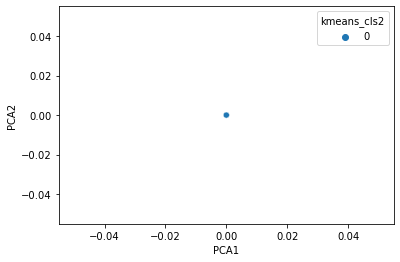

In [442]:
import seaborn as sns
sns.scatterplot(data=window_reads,x='PCA1',y='PCA2',hue='kmeans_cls2')